# How to use kernelSmoothing function of the btbpy library

### Install and Import btbpy
To install the btbpy library, enter the following command in the Console: `python -m pip install btbpy`

Or you can copy/paste the following code in a python script:

`
import os
try:
    import btbpy
except:
    os.system('cmd /c "python -m pip install btbpy"')
    import btbpy
`

In [29]:
import os
try:
    import btbpy
except:
    os.system('cmd /c "python -m pip install btbpy"')
    import btbpy
import pandas
import geopandas


### How to use data of the library

In [30]:
chem_data_dir = os.path.join(os.path.dirname(btbpy.__file__),'data')
#chem_data_dir = os.path.join('F:/btbpy_gitlab/btbpy/btbpy/data')
chem_data_carb = os.path.join(chem_data_dir, 'dfPrix_SP95_2016.csv')
chem_data_grid = os.path.join(chem_data_dir, 'fr_metro_grid1km.csv')
chem_data_reunion = os.path.join(chem_data_dir, 'reunion_epsg32740.csv')
chem_data_reunion_grid = os.path.join(chem_data_dir, 'reunion_grid200m_epsg32740.csv')
chem_data_reunion_com = os.path.join(chem_data_dir, 'commune_reg_04_2018.shp')
chem_output = os.path.join(os.path.dirname(btbpy.__file__),'examples')
#chem_output = os.path.join('F:/btbpy_gitlab/btbpy/btbpy/examples')

## First example : price of gas in France

### Import the data and the grid

In [31]:
carburants = pandas.read_csv(chem_data_carb) #the data
fr_1km = pandas.read_csv(chem_data_grid) #the grid

### Smoothing the data
The data contains two numeric variables which are going to be smoothed: 
- one is the price of gas (SP95) observed in a gas station  
- one is the number of gas station (which is 1 for all lines)  

We have to add this last variable in order to compute later a smoothed price.

In [32]:
gridResultat = btbpy.kernelSmoothing(
    carburants, #the data
    '2154', #the epsg code of the geographic projection
    1000, #the size (in meters) of the edge of grid's squares
    50000, #the bandwidth (in meters)
    fr_1km #the grid provided by user
)

-------------------------------------------------
number of asked cores : 1
-------------------------------------------------
start of smoothing loop
-------------------------------------------------
-------------------------------------------------
end of smoothing loop - duration time in seconds = 6.659522533416748
-------------------------------------------------
-------------------------------------------------
start of the final grid map cooking
-------------------------------------------------
	-------------------------------------------------
	start of making polygons
	-------------------------------------------------
	-------------------------------------------------
	end of making polygons - duration in seconds = 4.406272888183594
	-------------------------------------------------
	start of saving geodataframe
	-------------------------------------------------
	-------------------------------------------------
	end of saving geodataframe - duration in seconds = 0.0781037807464

### Compute the smoothed price

In [33]:
gridResultat['prixSP95'] = gridResultat.SP95/gridResultat.nbStations

In [34]:
gridResultat.describe()

,x,y,nbStations,SP95,prixSP95
count,5.484950e+05,5.484950e+05,548495.000000,548495.000000,548495.000000
mean,6.675650e+05,6.601323e+06,0.010161,0.013970,1.376131
std,2.137152e+05,2.358631e+05,0.005796,0.007995,0.025013
min,1.000000e+05,6.050000e+06,0.000395,0.000543,1.319457
25%,5.040000e+05,6.398000e+06,0.006264,0.008620,1.361845
50%,6.630000e+05,6.617000e+06,0.008618,0.011810,1.372613
75%,8.320000e+05,6.801000e+06,0.012630,0.017342,1.384677
max,1.242000e+06,7.110000e+06,0.054770,0.077149,1.650728


### Draw a map

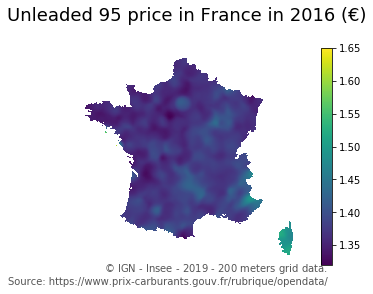

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
gridResultat.plot(column='prixSP95', ax=ax, legend=True)
plt.axis('off')
plt.title("Unleaded 95 price in France in 2016 (€)\n",size=18)
caption = ax.text(
    1.1, -0.1,
    '$\copyright$ IGN - Insee - 2019 - 200 meters grid data.\nSource: https://www.prix-carburants.gouv.fr/rubrique/opendata/',
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes
)

## Second example: Poverty rate on the Isle of La Réunion

In this example, the grid is not provided by the user but directly computed by the `kernelSmoothing()` function.

To compute the smoothed poverty rate, we, first, have to smooth the number of poor households and the whole number of households, and then divide the first smoothed one by the second smoothed one.

In [36]:
reunion = pandas.read_csv(chem_data_reunion) #the data
reu_com = geopandas.read_file(chem_data_reunion_com) #boundaries of the municipalities

### Smoothing the data

In [37]:
reunion_pauv_liss = btbpy.kernelSmoothing(
    reunion, #data to smooth
    '32740', #epsg code of the geographic projection
    200, # size of edge of the grid's squares
    400 # bandwidth (in meters)
)

-------------------------------------------------
number of asked cores : 1
-------------------------------------------------
start of smoothing loop
-------------------------------------------------
-------------------------------------------------
end of smoothing loop - duration time in seconds = 0.031213045120239258
-------------------------------------------------
-------------------------------------------------
start of the final grid map cooking
-------------------------------------------------
	-------------------------------------------------
	start of making polygons
	-------------------------------------------------
	-------------------------------------------------
	end of making polygons - duration in seconds = 0.10945606231689453
	-------------------------------------------------
	start of saving geodataframe
	-------------------------------------------------
	-------------------------------------------------
	end of saving geodataframe - duration in seconds = 0.0
	-----

### Compute the smoothed poverty rate

In [39]:
reunion_pauv_liss = reunion_pauv_liss[(reunion_pauv_liss.houhold > 0)]
reunion_pauv_liss['poverty_rate'] = reunion_pauv_liss.phouhold/reunion_pauv_liss.houhold*100
reunion_pauv_liss.describe()

,x,y,houhold,phouhold,poverty_rate
count,14076.000000,1.407600e+04,14076.000000,14076.000000,14076.000000
mean,342828.374538,7.662700e+06,19.369210,6.103296,32.502801
std,14611.276764,1.697827e+04,24.624163,9.214504,13.581391
min,314700.000000,7.634300e+06,0.215661,0.000000,0.000000
25%,328700.000000,7.647300e+06,4.760315,1.385766,23.248487
50%,343500.000000,7.662700e+06,11.273997,3.188617,32.465839
75%,354100.000000,7.678900e+06,24.247620,6.800204,41.327767
max,378700.000000,7.691100e+06,249.764706,100.931238,78.947368


###  Draw a map

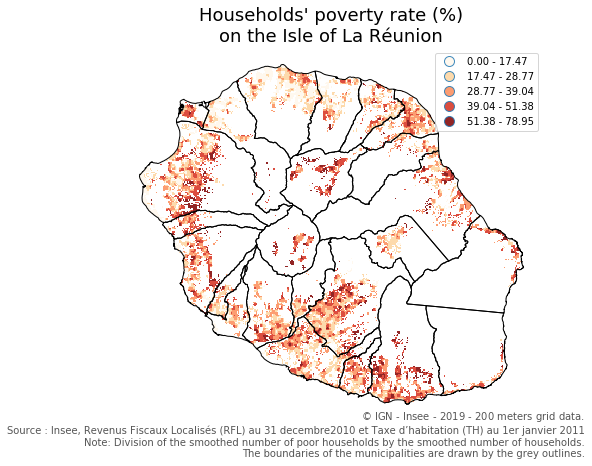

In [40]:
fig, ax = plt.subplots(1,figsize=(8, 8))
reunion_pauv_liss.plot('poverty_rate', ax=ax, legend = True, cmap='OrRd', scheme='Fisher_Jenks', alpha = 0.85)
reu_com.plot(ax=ax, facecolor='none', edgecolor = 'k',linewidths=1)
plt.axis('off')
plt.title("Households' poverty rate (%)\non the Isle of La Réunion",size=18)
ax.text(
    1.1, -0.1,
    '$\copyright$ IGN - Insee - 2019 - 200 meters grid data.\nSource : Insee, Revenus Fiscaux Localisés (RFL) au 31 décembre 2010 et Taxe d’habitation (TH) au 1er janvier 2011\nNote: Division of the smoothed number of poor households by the smoothed number of households.\nThe boundaries of the municipalities are drawn by the grey outlines.',
    ha='right', va='bottom',
    size=10,
    color='#555555',
    transform=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(chem_output, 'poverty_La_Reunion.png'), dpi=180, alpha=True)
plt.show()